In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
from minst_read import MnistDataloader
input_path = './'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train_num, y_train_num), (x_test_num, y_test_num) = mnist_dataloader.load_data()


x_train = x_train_num[:50000].reshape(50000,-1).astype(np.float32)/255
y_train = y_train_num[:50000].reshape(50000,1)

x_val = x_train_num[50000:].reshape(10000,-1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000,1)

x_test = x_test_num.copy().reshape(10000,-1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000,1)

def plot_number(image):
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

def create_minibaches(mb_size, x, y, shuffle = True):
    assert x.shape[0] == y.shape[0], 'Diferente tamaño'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

def init_parameters(input_size, neurons):
    '''
    input_size -> elementos de entrrada , 784
    newurons -> list [200,10] nro de neuronas por capa
    '''

    W1 = np.random.randn(neurons[0], input_size) * 0.001
    b1 = np.zeros((neurons[0],1))

    W2 = np.random.randn(neurons[1],neurons[0]) * 0.001
    b2 = np.zeros((neurons[1],1))
    return {'W1':W1,'b1':b1, 'W2':W2, 'b2':b2}


def relu(x):
    return np.maximum(0,x)

def scores(x,parameters,activation_fnc):
    """
    x tiene la forma (#pixeles,num samples)
    """
    z1 = parameters['W1'] @ x + parameters['b1']
    a1 = activation_fnc(z1) # devuelve func activation 
    z2 = parameters['W2'] @ a1 + parameters['b2']
    return z2, z1, a1



def softmax(x):
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores,axis=0)
    probs = exp_scores/sum_exp_scores
    return probs

def x_entropy(scores,y,batch_size=64):
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    return probs, cost

def backward(probs, x, y, z1, a1 , scores, parameters, batch_size=64):
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #y_hat - y
    dz2 = probs.copy()

    dW2 = dz2 @ a1.T / batch_size
    db2 = np.sum(dz2, axis=1, keepdims=True) / batch_size
    da1 = parameters['W2'].T @ dz2

    dz1 = da1.copy()
    dz1[z1 <= 0] = 0

    dW1 = dz1 @ x
    db1 = np.sum(dz1, axis=1, keepdims=True) / batch_size

    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'

    grads = {'w1':dW1, 'b1': db1, 'w2': dW2, 'b2':db2}
    return grads



def accuracy(x_data,y_data,mb_size=64):
    correct = 0
    total = 0
    for i, (x,y) in enumerate(create_minibaches(mb_size,x_data,y_data)):
        scores2, z1,a1 = scores(x.T, parameters, relu)
        y_hat, cost  = x_entropy(scores2,y , batch_size=len(x))
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]

    return correct/total


def train(epochs, parameters, mb_size, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i , (x,y) in enumerate(create_minibaches(mb_size, x_train, y_train)):
            scores2, z1, a1 = scores(x.T, parameters, activation_fnc=relu)
            y_hat, cost = x_entropy(scores2,y , batch_size=len(x))
            grads = backward(y_hat,x,y,z1,a1,scores2,parameters, batch_size=len(x))

            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['w2']
        print(f'cost es: {cost}, y accuray: {accuracy(x_val, y_val, mb_size)}')

    return parameters

parameters = init_parameters(28*28,[200,10])
#scores, z1 , a1 = scores(x_train[:64].T, parameters, relu)
#y_hat, cost = x_entropy(scores,y_train[:64])
#grads = backward(y_hat, x_train[:64], y_train[:64],z1, a1, scores, parameters)

mb_size = 512
learning_rate = 1e-2
epochs = 20
parameters_train = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)


# print(parameters['W1'].shape)
# print(parameters['b1'].shape)
# print(parameters['W2'].shape)
# print(parameters['b2'].shape)


# rnd_idx = np.random.randint(len(y_test))
# print(f'La imagen mostrada representa un: {y_test[rnd_idx]})')
# plot_number(x_test_num[rnd_idx])


# print(x_train.shape) #shape (50000,784)
# print(y_train.shape) #shape (50000,1)

# print(x_val.shape) #shape(10000,784)
# print(y_val.shape) #shape(10000,1)

# print(x_test.shape) #shape(10000,784)
# print(y_test.shape) #shape(10000,1)

cost es: 0.6012918963363998, y accuray: 0.869
cost es: 0.446413044576275, y accuray: 0.9038
cost es: 0.2974765023444454, y accuray: 0.9153
cost es: 0.2999230542395316, y accuray: 0.9237
cost es: 0.3083297608658433, y accuray: 0.9303
cost es: 0.28727411161924077, y accuray: 0.9353
cost es: 0.1797867301771783, y accuray: 0.9418
cost es: 0.2860645885989556, y accuray: 0.9461
cost es: 0.1391533896255067, y accuray: 0.9489
cost es: 0.25358686516183415, y accuray: 0.9542
cost es: 0.1814232106504618, y accuray: 0.9552
cost es: 0.19456866106832935, y accuray: 0.9575
cost es: 0.18711101835115412, y accuray: 0.9591
cost es: 0.17748024282259647, y accuray: 0.9611
cost es: 0.1747255616915876, y accuray: 0.9628
cost es: 0.14896010519816466, y accuray: 0.9637
cost es: 0.13547701229725284, y accuray: 0.9645
cost es: 0.1533915524792758, y accuray: 0.9656
cost es: 0.13773688129927852, y accuray: 0.9661
cost es: 0.1333691355480657, y accuray: 0.9655


In [3]:
accuracy(x_train,y_train, mb_size)

0.97098

In [1]:
accuracy(x_test,y_test, mb_size)

NameError: name 'accuracy' is not defined

In [5]:
def predict(x):
    scores2, _, _ = scores(x,parameters,relu)
    return np.argmax(scores2)

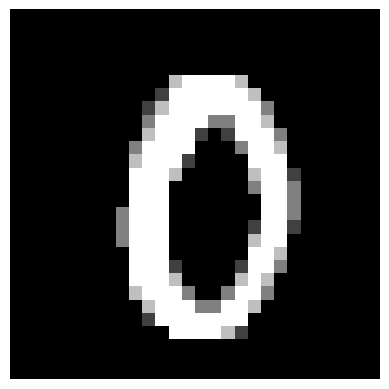

valor predicho es: 0


In [17]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = predict(x_test[idx].reshape(-1,1))
print(f'valor predicho es: {pred}')